In [120]:
import pandas as pd
import spacy
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

import utils_data as ud
import preprocess as prep

from pprint import pprint
from pandas.io.json import json_normalize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2
%timeit

pd.set_option('display.max_columns', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and check data

In [77]:
reviews = pd.read_hdf("data/mal_reviews.hdf5", "table")

In [78]:
reviews.iloc[0]

mal_id                                                 10030
reviews    [{'date': '2011-11-11T19:50:00+00:00', 'review...
title                                    Bakuman. 2nd Season
Name: 0, dtype: object

In [79]:
reviews.iloc[0]["reviews"][0]

{'content': "Overall I give Bakuman season 2 a 10! Maybe I'm just biased, but to me it deserves it.\r\nIf you enjoyed Bakuman Season 1 then you MUST See Bakuman Season 2, anyone who enjoyed Bakuman Season 1 as much as I should agree with my rating of 10 for season 2.\r\nSome anime's are good, and their second seasons are just a drag, but with Bakuman, season 1 was great and season 2 is even better! The story continues from season 1, even after season 1 I wanted to see what happened next and I still feel the same now in season 2 at episode 6.\r\nStory: 10\r\nUnlikemany anime's Bakuman is realistic. It shows many hardships throughout the story that the characters go through, just when things get better a new tragedy occurs. It really says something about real life, the realistic plot is one of Bakuman's greatest traits and it helps as get into the story even more when we feel the hardships as the characters feel them.\\n\\n\r\nCharacters: 10\\n\r\nAlmost all the characters in Bakuman are

In [80]:
reviews_list = []
for index, row in reviews.iterrows():
    df = json_normalize(row["reviews"])
    df.rename(columns={"mal_id": "review_id"}, inplace=True)
    df["mal_id"] = row["mal_id"]
    df["title"] = row["title"]
    reviews_list.append(df)

In [81]:
reviews = pd.concat(reviews_list)

In [82]:
reviews.columns

Index(['content', 'date', 'helpful_count', 'review_id',
       'reviewer.episodes_seen', 'reviewer.image_url',
       'reviewer.scores.animation', 'reviewer.scores.character',
       'reviewer.scores.enjoyment', 'reviewer.scores.overall',
       'reviewer.scores.sound', 'reviewer.scores.story', 'reviewer.url',
       'reviewer.username', 'url', 'mal_id', 'title'],
      dtype='object')

### Drop and rearrange

In [83]:
reviews.drop(labels=["reviewer.image_url", "reviewer.url", "url"], axis=1, inplace=True)

In [84]:
# Reorganize
mal_id = reviews["mal_id"]
title = reviews["title"]
review_id = reviews["review_id"]
reviewer = reviews["reviewer.username"]
reviews.drop(labels=["mal_id", "title", "review_id", "reviewer.username"], axis=1, inplace=True)
reviews.insert(0, "mal_id", mal_id)
reviews.insert(1, "title", title)
reviews.insert(2, "review_id", review_id)
reviews.insert(3, "reviewer", reviewer)

In [85]:
reviews.describe()

,mal_id,review_id,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story
count,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000,81519.000000
mean,18180.403023,180208.666397,28.664311,18.309572,7.502582,6.908696,7.204100,7.314270,7.376096,6.620076
std,12069.788246,89600.772751,102.697117,68.034048,2.392581,2.902133,2.918456,2.284119,2.422250,2.766798
min,15.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,7054.000000,107340.000000,3.000000,12.000000,7.000000,5.000000,6.000000,6.000000,6.000000,5.000000
50%,16706.000000,200539.000000,6.000000,12.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000
75%,30727.000000,254712.000000,16.000000,23.000000,9.000000,9.000000,10.000000,9.000000,9.000000,9.000000
max,37991.000000,307885.000000,4091.000000,9001.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


### Look at word distributions

In [86]:
reviews.isna().sum()

mal_id                       0
title                        0
review_id                    0
reviewer                     0
content                      0
date                         0
helpful_count                0
reviewer.episodes_seen       0
reviewer.scores.animation    0
reviewer.scores.character    0
reviewer.scores.enjoyment    0
reviewer.scores.overall      0
reviewer.scores.sound        0
reviewer.scores.story        0
dtype: int64

In [87]:
reviews["date"] = pd.to_datetime(reviews["date"], infer_datetime_format=True)

I'm mainly interested in `content`, though `helpful_count` and `reviewers.episodes_seen` can be helpful.

In [88]:
# look at word distributions
word_map = Counter()
for i, (index, row) in enumerate(reviews.iterrows()):
    if i % 1000 == 0:
        print(i)
    for word in row['content'].split(" "):
        word = word.lower()
        if word not in word_map:
            word_map[word] = 1
        else:
            word_map[word] += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000


In [89]:
word_map.most_common(100)

[('the', 2546622),
 ('and', 1244474),
 ('to', 1121009),
 ('of', 1112938),
 ('a', 1093299),
 ('is', 830536),
 ('i', 644665),
 ('that', 616704),
 ('in', 609862),
 ('it', 600604),
 ('this', 474106),
 ('but', 368692),
 ('for', 360676),
 ('with', 350459),
 ('as', 349299),
 ('was', 309219),
 ('you', 295873),
 ('are', 285363),
 ('not', 239818),
 ('anime', 236064),
 ('be', 227042),
 ('', 208560),
 ('they', 207669),
 ('on', 203547),
 ('have', 203102),
 ('like', 197789),
 ('characters', 177071),
 ('just', 174568),
 ('at', 165855),
 ('so', 164388),
 ('all', 161726),
 ('show', 161314),
 ('one', 159764),
 ('an', 158608),
 ('really', 155221),
 ('from', 153377),
 ('or', 153291),
 ('more', 147679),
 ('some', 143498),
 ('if', 139597),
 ('about', 139327),
 ('story', 136232),
 ('he', 130079),
 ("it's", 129535),
 ('character', 129105),
 ('her', 127673),
 ('what', 127407),
 ('has', 127265),
 ('there', 125158),
 ('very', 124910),
 ('their', 123973),
 ('by', 118238),
 ('his', 115287),
 ('my', 113762),
 ('who

In [90]:
count = 0
for k, v in word_map.items():
    if v >= 2:
        count += 1
print(count)

442733


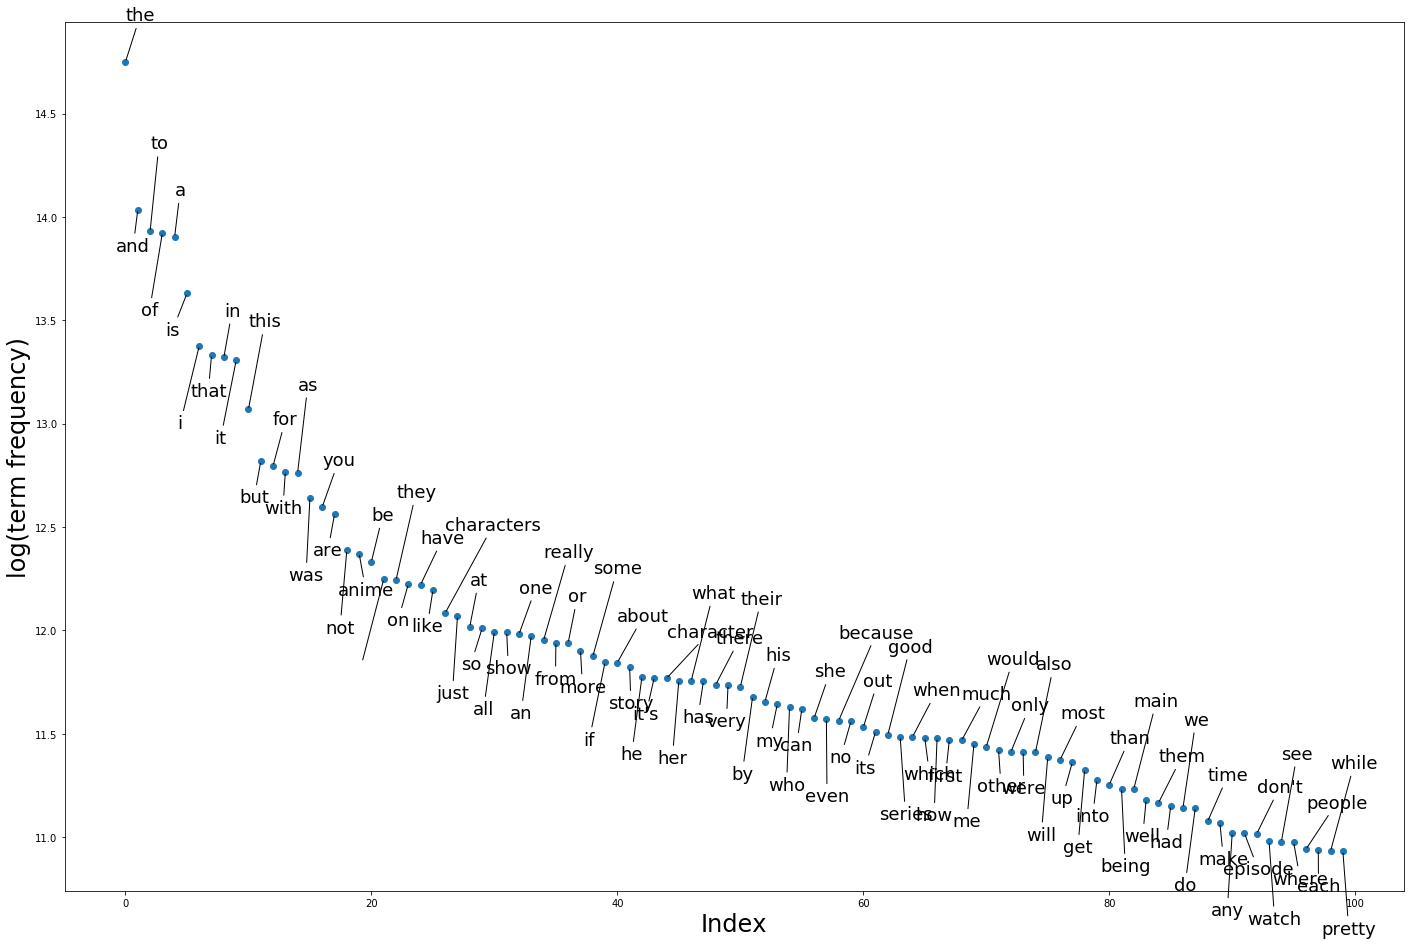

In [91]:
ud.plot_normalized_word_counts(word_map, 100)

I'm not going to remove any stop words, since we may lose some important information.

Also remember to split data into training and testing, before training document vectors.

###  Drop duplicates

In [92]:
reviews["review_id"].value_counts()

266242    2
236312    2
281314    2
27366     2
28611     2
58103     2
292800    2
215685    2
114617    2
119569    2
202668    2
32997     2
213827    2
242461    2
214950    2
39727     2
144173    2
49971     2
190354    2
168761    2
179004    2
172863    2
152289    2
238303    2
184279    2
205519    2
196655    2
18290     2
172059    2
94853     2
         ..
299445    1
172467    1
305586    1
229847    1
276960    1
287275    1
29055     1
29225     1
89027     1
30920     1
252444    1
123419    1
14654     1
90635     1
225801    1
197127    1
201221    1
250389    1
135653    1
57851     1
190970    1
295415    1
139997    1
168437    1
307697    1
279023    1
156139    1
291305    1
2534      1
208698    1
Name: review_id, Length: 63789, dtype: int64

In [93]:
reviews.loc[reviews["review_id"] == 236312]

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story
0,31339,Drifters,236312,Stark700,Drifters is the type of show that you’ll quick...,2016-12-23 20:32:00+00:00,145,12,8,9,8,8,7,7
20,31339,Drifters,236312,Stark700,Drifters is the type of show that you’ll quick...,2016-12-23 20:32:00+00:00,145,12,8,9,8,8,7,7


So I collected duplicate reviews. I'll need to get rid of those.

I also found a review that is in spanish... this means the corpus may contain reviews in different languages (e.g. chinese, japanese, etc)

In [94]:
reviews.drop_duplicates(inplace=True)

In [95]:
reviews.shape # consider using 13789 for testing (which is ~80:20 -- more of 79:21)

(63789, 14)

In [96]:
reviews.memory_usage(deep=True).sum()

335419343

### Check number of reviews for each anime

In [97]:
reviews["mal_id"].value_counts()

6045     180
22319    180
7724     180
28171    180
14813    180
15809    180
6547     180
934      180
11061    180
16498    180
3588     180
1210     180
20507    180
849      180
22199    180
30015    180
13759    180
2001     180
18679    180
30276    180
17895    180
31240    180
16067    180
457      180
9919     180
15085    180
2251     180
22535    180
31859    180
8074     180
        ... 
35972     13
32083     12
4548      12
65        12
28979     12
10379     11
846       11
35843     11
32603     11
24701     11
5690      11
15699     11
20509     11
31722     11
10073     10
29067      9
19647      8
5262       8
32983      8
27525      8
24277      8
15417      8
32595      7
3091       7
15377      6
31098      6
22777      4
6377       4
31821      3
3228       2
Name: mal_id, Length: 915, dtype: int64

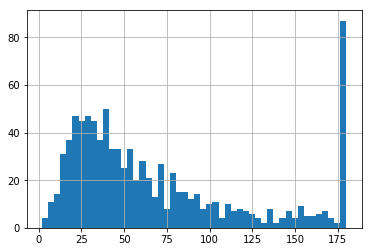

In [98]:
reviews["mal_id"].value_counts().hist(bins=50)

In [99]:
freq_threshold = 80
print(sum(reviews["mal_id"].value_counts() >= freq_threshold))
print(sum(reviews["mal_id"].value_counts() < freq_threshold))
print(296/915)

296
619
0.32349726775956283


What is the average score for an anime with at least 80 reviews? (the top 32% most reviewed)

In [100]:
most_reviewed = reviews.groupby("mal_id").filter(
    lambda x: x["reviewer.scores.overall"].count() >= freq_threshold)
least_reviewed = reviews.groupby("mal_id").filter(
    lambda x: x["reviewer.scores.overall"].count() < freq_threshold)

In [101]:
most_reviewed.groupby("mal_id")["reviewer.scores.overall"].mean()

mal_id
79       7.023622
101      7.574324
150      8.175000
237      8.462500
355      7.614458
356      7.129213
457      8.916667
790      8.098684
849      7.616667
853      8.633333
857      7.862745
877      8.844444
889      8.323171
934      8.327778
1195     6.677686
1210     8.583333
1222     7.042105
1292     7.262136
1482     8.519084
1530     8.451613
1535     8.766667
1571     8.464646
1575     7.872222
1604     8.677778
1691     7.040404
1698     8.804348
1699     8.111111
1726     6.575000
1735     7.538889
1818     7.836257
           ...   
34618    7.000000
34662    5.682243
34798    8.612613
34822    8.816667
34902    7.609756
34933    6.538922
34934    5.510638
35062    7.689189
35076    5.964602
35203    5.727778
35507    7.098039
35557    8.527778
35639    7.187500
35839    9.096552
35847    7.000000
35849    6.294444
35860    7.588235
35994    6.185185
36027    3.839416
36038    7.676471
36296    8.125000
36456    7.559524
36474    6.598131
36475    6.609756
365

In [102]:
least_reviewed.groupby("mal_id")["reviewer.scores.overall"].mean()

mal_id
15       8.156250
16       8.328125
27       6.978261
50       7.829787
65       8.000000
67       7.750000
68       7.243243
73       8.375000
149      6.733333
157      6.344828
177      7.088889
198      7.536585
228      8.025974
248      6.185185
322      8.081967
390      7.031250
469      7.648649
477      7.913793
479      7.923077
487      7.333333
587      7.656250
710      8.097561
846      8.545455
855      7.800000
856      7.909091
861      8.142857
918      8.400000
935      7.184211
969      7.315789
1142     9.136364
           ...   
35968    7.876712
35972    7.461538
36023    5.277778
36028    7.870968
36049    7.263158
36220    7.173913
36266    5.666667
36432    4.709677
36470    6.741935
36516    5.421053
36548    7.111111
36649    8.152778
36726    6.869565
36793    5.612903
36949    7.000000
37105    7.705882
37141    7.480000
37171    8.220339
37259    6.151515
37446    3.538462
37475    7.300000
37497    7.028986
37517    6.479452
37569    6.170732
376

In [103]:
# as a sanity check to see if the groupings are correct... 
# Eromanga is highly reviewed, but not because it's good!
most_reviewed.loc[most_reviewed["mal_id"] == 32901]

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story
0,32901,Eromanga-sensei,250858,HaXXspetten,I don't normally tend to point fingers at peop...,2017-06-24 08:46:00+00:00,1080,12,6,8,9,8,8,5
1,32901,Eromanga-sensei,246562,CoquiEnthusiast,Something I find hilarious is that no one can ...,2017-04-29 09:52:00+00:00,822,4,3,1,1,1,2,1
2,32901,Eromanga-sensei,250878,Veronin,"For better and for worse (mostly worse), Eroma...",2017-06-24 12:06:00+00:00,621,12,8,2,3,3,7,3
3,32901,Eromanga-sensei,250866,LIQfilms,Eromanga-sensei is a culmination of everything...,2017-06-24 10:12:00+00:00,256,12,5,1,2,2,5,1
4,32901,Eromanga-sensei,250870,TakamakiJoker,After watching Eromanga Sensei my eyes have op...,2017-06-24 11:02:00+00:00,90,12,2,1,1,1,5,1
5,32901,Eromanga-sensei,250890,Artrill,[1/10]\r\n____________________________________...,2017-06-24 14:08:00+00:00,47,12,3,1,1,1,1,1
6,32901,Eromanga-sensei,255047,themegamancave,Unless you’ve been living under a rock for the...,2017-08-09 08:28:00+00:00,30,12,7,1,1,1,3,1
7,32901,Eromanga-sensei,250954,Rikuto-kun,"This show is trash and so am I.\r\n""I love pen...",2017-06-25 00:58:00+00:00,27,12,7,8,8,8,6,3
8,32901,Eromanga-sensei,249983,Moelester18,The show ups the boundaries for what a bad sho...,2017-06-15 15:35:00+00:00,23,10,6,5,10,10,4,2
9,32901,Eromanga-sensei,281059,literaturenerd,"Introduction:\r\nYeah, I know I'm WAY late to ...",2018-05-20 22:01:00+00:00,15,12,2,2,2,2,2,2


In [104]:
# same with tokyo ghoul:re
most_reviewed.loc[most_reviewed["mal_id"] == 36511]

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story
0,36511,Tokyo Ghoul:re,278868,Karhu,Tokyo Kushu Re is bad excuse for a sequel. The...,2018-04-24 07:32:00+00:00,231,4,0,0,0,4,0,0
1,36511,Tokyo Ghoul:re,281562,CthulhusDong,!!POSSIBLE SPOILERS IN THIS REVIEW!!\r\nI'll s...,2018-06-19 09:33:00+00:00,148,12,5,8,5,5,7,8
2,36511,Tokyo Ghoul:re,281565,GMoney84,Tokyo Ghoul except everything that was good is...,2018-06-19 10:06:00+00:00,141,12,6,4,5,5,6,5
3,36511,Tokyo Ghoul:re,282367,Seijatachiiii,This show is a hot mess. It is confusing due t...,2018-06-27 11:45:00+00:00,77,12,2,4,1,1,4,3
4,36511,Tokyo Ghoul:re,281554,AlexTenshi,Note: This is a review coming from an anime on...,2018-06-19 08:41:00+00:00,74,12,7,8,7,8,9,9
5,36511,Tokyo Ghoul:re,278874,radical_autism,"For me as a long-term Tokyo Ghoul fan, the new...",2018-04-24 08:38:00+00:00,63,4,7,4,5,5,6,4
6,36511,Tokyo Ghoul:re,279537,an1mnte,"[Spoiler Warning]\r\n0/10, Unfortunately a hug...",2018-05-01 19:22:00+00:00,21,5,5,1,1,1,1,1
7,36511,Tokyo Ghoul:re,279517,Pizco,Don't watch this anime.\r\nWhether or not you'...,2018-05-01 15:24:00+00:00,19,5,3,3,1,3,3,4
8,36511,Tokyo Ghoul:re,279001,MasterAdventZero,-Tokyo Ghoul:re (anime)-\r\n-Episode Watched: ...,2018-04-25 15:20:00+00:00,15,4,2,3,2,3,9,3
9,36511,Tokyo Ghoul:re,281441,magaiverix,"A couple of days ago, I decided not to wait, u...",2018-05-26 15:27:00+00:00,14,8,8,7,10,8,8,7


In [105]:
most_reviewed.groupby("title")["mal_id"].count()

title
11eyes                                                       94
3-gatsu no Lion                                             102
91 Days                                                     119
Absolute Duo                                                114
Accel World                                                 168
Acchi Kocchi (TV)                                            84
Afro Samurai                                                103
Air                                                         148
Air Gear                                                    102
Ajin                                                        121
Akagami no Shirayuki-hime                                   100
Akame ga Kill!                                              180
Akatsuki no Yona                                            180
Aku no Hana                                                 130
Akuma no Riddle                                              81
Aldnoah.Zero                      

In [106]:
least_reviewed.groupby("title")["mal_id"].count()

title
07-Ghost                                                                   75
3-gatsu no Lion 2nd Season                                                 57
3D Kanojo: Real Girl                                                       62
A-Channel                                                                  30
ACCA: 13-ku Kansatsu-ka                                                    54
Aa! Megami-sama! (TV)                                                      47
Aho Girl                                                                   77
Ajin 2nd Season                                                            24
Akagami no Shirayuki-hime 2nd Season                                       17
Akaneiro ni Somaru Saka                                                    64
Akiba's Trip The Animation                                                 33
Akikan!                                                                    41
Aldnoah.Zero 2nd Season                                   

It wouldn't make sense to sample and evaluate from `most_reviewed`. I'll just do random sampling from reviews -- not just for evaluating the embeddings, but also for evaluating the models.

### Split Data
Do a 95-5 split

In [107]:
train_reviews, test_reviews = train_test_split(reviews, train_size=0.95, random_state=1)

### Doc2Vec embeddings grouped by anime
- the vectors are trained such that reviews with the same anime (mal_id) have the same tag

In [109]:
num_reviews = train_reviews.shape[0]
load_tagged_docs = False

if os.path.exists("models/grouped_by_anime/train_doc2vec.model"):
    model = Doc2Vec.load("models/grouped_by_anime/train_doc2vec.model")
    if load_tagged_docs and os.path.exists("models/grouped_by_anime/tagged_docs.pkl"):
        with open("models/grouped_by_anime/tagged_docs.pkl", "rb") as f:
            tagged_docs = pickle.load(f)
else:
    nlp = spacy.load("en_core_web_lg")
    tagged_docs = []
    for i, (index, row) in enumerate(train_reviews.iterrows()):
        if i == num_reviews:
            break
        else:
            doc = prep.tokenize_text(row["content"], nlp)
            tagged_docs.append(TaggedDocument([word for word in doc.text.split(" ")], [i, num_reviews + row["mal_id"]]))
    
    model = Doc2Vec(vector_size=100, min_count=5, 
                workers=10, epochs=20, dm=1, hs=1)

    model.build_vocab(tagged_docs)

    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)

    model.save("models/grouped_by_anime/train_doc2vec.model")
    with open("models/grouped_by_anime/tagged_docs.pkl", "wb") as f:
        pickle.dump(tagged_docs, f)

In [34]:
query = train_reviews.iloc[54406]["content"]
query = """
The music is amazing too; especially the opening songs. I don't think I've skipped over them more than about twice, not counting the episodes I clicked on just to skip to my favourite parts. When the music kicks in, usually in a pivotal moment, you're on the edge of your seat waiting with bated breath to see what happens.
"""
print(query)

v = model.infer_vector([x.lower() for x in query.split(" ")])


The music is amazing too; especially the opening songs. I don't think I've skipped over them more than about twice, not counting the episodes I clicked on just to skip to my favourite parts. When the music kicks in, usually in a pivotal moment, you're on the edge of your seat waiting with bated breath to see what happens.



In [35]:
topn = 5
rankings = model.docvecs.most_similar([v], topn=topn, clip_start=0, clip_end=num_reviews)
rankings

[(8735, 0.36727291345596313),
 (25716, 0.3608722686767578),
 (20652, 0.3535733222961426),
 (54324, 0.33286601305007935),
 (17601, 0.32528409361839294)]

In [36]:
if tagged_docs:
    for i in range(topn):
        print("-" * 35 + " " + str(i) + " " + "-" * 35)
        print(" ".join(tagged_docs[rankings[i][0]].words))

----------------------------------- 0 -----------------------------------
i 'm crying i just finished the series the first few episodes the art is like terrible but if you watch it some more it gets better after episode you get hooked on this anime trust me when you start watching this you will not watch another anime on second hand because this anime is to awesome to watch another when the anime ends you get so emotional because you get so attached to the characters and its hard to say goodbye and this anime was episodes so i bet by now you fell inlove with someone i fell inlove with gokuderaand hibari primo when the anime ended my heart ached i cried because i will miss then because i know i will never see then again characters so unique like then i m sorry typing this makes me cry 
----------------------------------- 1 -----------------------------------
hanayamata is n't good enough to compete with all the available cgdct anime it 's good but it 's not great however hanayamata 's c

In [43]:
# check if trained documents' embeddings are in top 2
num_docs = 10
i = 0
correct = 0
for idx in train_reviews.index:
    inferred_vector = model.infer_vector([word.lower() for word in train_reviews.iloc[idx]["content"].split(" ")])
    sims = model.docvecs.most_similar([inferred_vector], topn=2)
    if sims[0][0] == idx or sims[1][0] == idx:
        correct += 1
    if i >= num_docs:
        break
    i += 1

In [45]:
correct / num_docs

1.0

### Accessing the document and anime vectors
`idx` is the integer-location within `train_reviews`, for example, `Hourou Musuko` has an index id of `74`, but the integer-location index is `0`.

Index using `idx` to access the document vector for a particular review

Index using `train_reviews.shape[0] + train_reviews.iloc[idx]` to access anime vector

As a sanity check, make sure the vectors are similar to the original...

In [46]:
nlp = spacy.load("en_core_web_lg")

In [47]:
for i, (index, row) in enumerate(train_reviews.iterrows()):
    doc = prep.tokenize_text(row["content"], nlp)
    inferred_vector = model.infer_vector([word for word in doc.text.split(" ")])
    print(doc)
    break

this was a show i decided to watch on a whim on a day where i did n't have much to do it turned out to be a very good decision it left a good impression on me and after the second episode i just had to keep watching it straight through because it kept you wandering what would happen next even if you knew the possibilities i 've read a few bl 's here and there where a guy wants to be a girl and all kinds of drama unfolds to be honest that 's what attracted me to this show but the reverse about the girl wantingto be a boy was also pretty interesting i do n't quite relate to her yoshino but i 've been around similar people so it 's not strange to me at all personally i think this is of those before its time kind of series where it might take a while for people to catch onto it and it 's messages like how these days people are generally becoming more aware and acceptable of lgbt people i 'm not for labels and such so do n't feel offended i get offended myself when people rely on them too m

In [48]:
train_reviews.iloc[0]

mal_id                                                                    8426
title                                                            Hourou Musuko
review_id                                                               232931
reviewer                                                           catcupcakes
content                      This was a show I decided to watch on a whim o...
date                                                 2016-10-30 19:44:00+00:00
helpful_count                                                                1
reviewer.episodes_seen                                                      11
reviewer.scores.animation                                                    7
reviewer.scores.character                                                    8
reviewer.scores.enjoyment                                                    8
reviewer.scores.overall                                                      9
reviewer.scores.sound                               

In [49]:
model.docvecs.most_similar([inferred_vector], topn=2) # first pair is review, second pair is anime

[(0, 0.6746877431869507), (69025, 0.6316815614700317)]

In [50]:
train_reviews.iloc[0]["content"] # matches the review

'This was a show I decided to watch on a whim on a day where I didn\'t have much to do… it turned out to be a very good decision. It left a good impression on me, and after the second episode I just had to keep watching it straight through because it kept you wandering what would happen next, even if you knew the possibilities. I\'ve read a few bl\'s here and there where a guy wants to be a girl and all kinds of drama unfolds. To be honest that\'s what attracted me to this show, but the reverse about the girl wantingto be a boy was also pretty interesting. I don\'t quite relate to her (Yoshino), but I\'ve been around similar people so it\'s not strange to me at all. Personally, I think this is one of those "before its time" kind of series, where it might take a while for people to catch onto it and it\'s messages, like how these days people are generally becoming more aware and acceptable of lgbt people (I\'m not one for labels and such so don\'t feel offended…I get offended myself whe

In [51]:
train_reviews.iloc[0]["mal_id"]

8426

In [52]:
train_reviews.shape[0] + train_reviews.iloc[0]["mal_id"] # used # of rows + mal_id as the offset for the anime vector

69025

In [53]:
train_reviews.iloc[0]

mal_id                                                                    8426
title                                                            Hourou Musuko
review_id                                                               232931
reviewer                                                           catcupcakes
content                      This was a show I decided to watch on a whim o...
date                                                 2016-10-30 19:44:00+00:00
helpful_count                                                                1
reviewer.episodes_seen                                                      11
reviewer.scores.animation                                                    7
reviewer.scores.character                                                    8
reviewer.scores.enjoyment                                                    8
reviewer.scores.overall                                                      9
reviewer.scores.sound                               

### Create dataframe of document and anime vectors

In [54]:
model.docvecs.vectors_docs

array([[ 1.08073997e+00, -1.68932593e+00,  2.80989438e-01, ...,
         5.75997949e-01,  1.05817534e-01, -1.49693751e+00],
       [ 6.04440808e-01,  1.23566473e+00,  8.78976882e-01, ...,
        -2.81303072e+00,  2.91829288e-01, -1.07524526e+00],
       [ 1.93398011e+00,  1.04681171e-01,  2.44268075e-01, ...,
        -9.90715981e-01,  6.86148852e-02,  3.91139030e-01],
       ...,
       [-4.80586011e-03,  4.03468870e-03, -1.40943506e-03, ...,
         2.80000456e-03, -1.07321015e-03, -7.11429049e-04],
       [-3.65964160e-03,  1.96388597e-03,  2.31873244e-03, ...,
         2.10923539e-03,  2.08625058e-03, -1.55518076e-03],
       [ 1.70333624e-01,  1.03051829e+00,  1.51953593e-01, ...,
         2.06761435e-02, -1.37433565e+00, -2.99888492e-01]], dtype=float32)

In [55]:
train_reviews.shape

(60599, 14)

In [56]:
train_reviews["mal_id"].nunique()

915

In [57]:
train_reviews["mal_id"].max()

37991

In [58]:
model.docvecs.vectors_docs[0:60599].shape

(60599, 100)

In [67]:
train_docvecs = pd.DataFrame(data=model.docvecs.vectors_docs[0:60599]).add_prefix("doc_vec_")

In [113]:
train_vector = pd.DataFrame(pd.np.column_stack([train_reviews, model.docvecs.vectors_docs[0:60599]]))

In [116]:
train_vector.rename(columns={i:name for i, name in enumerate(train_reviews.columns)},
                    inplace=True)
train_vector.rename(columns={i:"docvec_"+str(i-14) for i in range(14,114)},
                    inplace=True)
train_vector.head()

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story,docvec_0,docvec_1,docvec_2,docvec_3,docvec_4,docvec_5,docvec_6,docvec_7,docvec_8,docvec_9,docvec_10,docvec_11,docvec_12,docvec_13,docvec_14,docvec_15,docvec_16,docvec_17,docvec_18,docvec_19,docvec_20,docvec_21,docvec_22,docvec_23,docvec_24,docvec_25,docvec_26,docvec_27,docvec_28,docvec_29,docvec_30,docvec_31,docvec_32,docvec_33,docvec_34,docvec_35,docvec_36,docvec_37,docvec_38,docvec_39,docvec_40,docvec_41,docvec_42,docvec_43,docvec_44,docvec_45,docvec_46,docvec_47,docvec_48,docvec_49,docvec_50,docvec_51,docvec_52,docvec_53,docvec_54,docvec_55,docvec_56,docvec_57,docvec_58,docvec_59,docvec_60,docvec_61,docvec_62,docvec_63,docvec_64,docvec_65,docvec_66,docvec_67,docvec_68,docvec_69,docvec_70,docvec_71,docvec_72,docvec_73,docvec_74,docvec_75,docvec_76,docvec_77,docvec_78,docvec_79,docvec_80,docvec_81,docvec_82,docvec_83,docvec_84,docvec_85,docvec_86,docvec_87,docvec_88,docvec_89,docvec_90,docvec_91,docvec_92,docvec_93,docvec_94,docvec_95,docvec_96,docvec_97,docvec_98,docvec_99
0,8426,Hourou Musuko,232931,catcupcakes,This was a show I decided to watch on a whim o...,2016-10-30 19:44:00+00:00,1,11,7,8,8,9,7,8,1.08074,-1.68933,0.280989,1.21398,1.25143,-1.50384,-1.4642,0.0134942,0.854812,-0.00159962,-0.981685,-0.0773778,-0.22189,-0.610173,0.852703,-0.716176,0.394199,0.199221,-0.771814,-0.0678699,1.10917,-0.893586,1.58154,0.178041,0.480514,-0.0141348,1.11474,0.925915,-0.309333,1.47207,-0.111341,-0.0103072,-0.567599,-0.0464922,-2.02807,-0.994556,0.765735,-0.0976452,-0.158931,-1.21036,0.522571,-0.518669,-0.119604,-1.1444,-1.55456,1.69326,-2.84797,1.27988,-0.166049,-0.209001,0.763666,0.489597,-2.23271,-0.394933,1.1101,1.31507,0.65598,0.384832,0.460551,-0.598246,0.163514,0.446881,0.415636,0.986113,-0.242324,-1.12611,1.06115,-1.11177,-0.392104,-0.00741897,0.456773,-0.201821,-0.922988,-0.590775,-1.17128,1.67591,-0.163367,-0.0629259,0.256743,0.182071,1.86297,1.7282,-0.777169,1.41911,-0.523093,-0.735064,-0.134833,-1.71446,0.154433,0.0984592,0.323704,1.27207,-0.584374,0.484996,1.4498,1.95805,2.06426,0.575998,0.105818,-1.49694
1,3712,Zero no Tsukaima: Princesses no Rondo,33853,ymir233,"I don't care how well a formula works, when it...",2011-01-18 08:39:00+00:00,71,12,7,7,7,6,9,3,0.604441,1.23566,0.878977,1.08737,-0.474285,-0.141517,1.03255,-0.278179,-0.45575,-1.95382,0.590932,-0.0492315,-0.524138,-1.74507,0.37826,0.514148,-0.291248,1.63904,-0.101752,0.0535754,-1.03328,0.287528,-0.29872,1.18554,-0.762641,-0.555532,-0.0261265,-1.35639,-1.12231,-0.022762,-1.53496,0.254654,-0.136406,0.195956,0.200714,-1.96919,-0.514229,0.897864,-1.5039,-0.518444,-0.543111,-0.505114,0.633079,-0.555414,0.0535161,-2.22525,-0.843581,-0.302368,-0.263229,-0.0795202,-1.88382,0.442215,0.95822,-1.759,-0.199507,2.42287,1.48974,1.27871,-0.42392,0.253818,0.651533,-0.622506,0.384946,0.992677,-0.0832083,-0.461164,-1.45853,-0.549319,-0.215845,0.950027,-1.0745,0.534737,-0.138289,-1.12927,0.327967,0.420651,-0.256837,0.856622,0.803996,1.98838,1.25869,0.157588,-1.42462,-0.470647,0.882508,-1.81363,0.884202,-0.487689,0.729301,-0.860453,-0.599642,0.380691,0.589956,1.89892,-0.314873,0.206817,-0.850226,-2.81303,0.291829,-1.07525
2,1604,Katekyo Hitman Reborn!,72813,Forever-Noir,This series was initially shown to me by a fri...,2012-09-20 22:24:00+00:00,8,203,9,10,10,10,10,10,1.93398,0.104681,0.244268,-2.46762,0.157275,0.0419904,1.06589,0.648777,-0.471577,-1.03424,-0.23285,0.287572,-1.1454,1.73756,-1.2572,-1.14462,-0.780555,0.185943,-1.77533,0.331497,0.434244,0.86305,1.07998,-2.24735,0.104764,-0.143045,-1.47054,0.117813,-0.82091,0.259683,-0.612903,-0.825757,-0.311609,-0.943932,0.304993,1.88874,-0.648574,0.599701,0.90085,1.31644,0.442801,-0.384226,-1.07564,1.59825,1.43468,1.05015,0.989226,1.23407,-0.0466677,-1.04522,2.00184,0.972005,-1.02558,0.0641584,0.90575,-0.431

In [132]:
train_vector.to_hdf("data/mal_reviews_df.hdf5", "table")

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->['mal_id', 'title', 'review_id', 'reviewer', 'content', 'date', 'helpful_count', 'reviewer.episodes_seen', 'reviewer.scores.animation', 'reviewer.scores.character', 'reviewer.scores.enjoyment', 'reviewer.scores.overall', 'reviewer.scores.sound', 'reviewer.scores.story', 'docvec_0', 'docvec_1', 'docvec_2', 'docvec_3', 'docvec_4', 'docvec_5', 'docvec_6', 'docvec_7', 'docvec_8', 'docvec_9', 'docvec_10', 'docvec_11', 'docvec_12', 'docvec_13', 'docvec_14', 'docvec_15', 'docvec_16', 'docvec_17', 'docvec_18', 'docvec_19', 'docvec_20', 'docvec_21', 'docvec_22', 'docvec_23', 'docvec_24', 'docvec_25', 'docvec_26', 'docvec_27', 'docvec_28', 'docvec_29', 'docvec_30', 'docvec_31', 'docvec_32', 'docvec_33', 'docvec_34', 'docvec_35', 'docvec_36', 'docvec

## Binning the scores
First need to identify the reviews for which the users only input an overall score but left all the other scores empty. I'll fill them in with the overall score.

In [129]:
train_vector = pd.read_hdf("data/mal_reviews_df.hdf5", "table")
train_vector = train_vector.infer_objects()

In [130]:
other_scores = ["reviewer.scores.animation",
                "reviewer.scores.character",
                "reviewer.scores.enjoyment",
                "reviewer.scores.sound",
                "reviewer.scores.story"]

In [131]:
all_zero_idx = ((train_vector["reviewer.scores.animation"] == 0) &
                (train_vector["reviewer.scores.character"] == 0) &
                (train_vector["reviewer.scores.enjoyment"] == 0) &
                (train_vector["reviewer.scores.sound"] == 0) & 
                (train_vector["reviewer.scores.story"] == 0))

In [132]:
train_vector.at[all_zero_idx, other_scores] = train_vector[all_zero_idx]["reviewer.scores.overall"]

In [133]:
train_vector[all_zero_idx]

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story,docvec_0,docvec_1,docvec_2,docvec_3,docvec_4,docvec_5,docvec_6,docvec_7,docvec_8,docvec_9,docvec_10,docvec_11,docvec_12,docvec_13,docvec_14,docvec_15,docvec_16,docvec_17,docvec_18,docvec_19,docvec_20,docvec_21,docvec_22,docvec_23,docvec_24,docvec_25,docvec_26,docvec_27,docvec_28,docvec_29,docvec_30,docvec_31,docvec_32,docvec_33,docvec_34,docvec_35,docvec_36,docvec_37,docvec_38,docvec_39,docvec_40,docvec_41,docvec_42,docvec_43,docvec_44,docvec_45,docvec_46,docvec_47,docvec_48,docvec_49,docvec_50,docvec_51,docvec_52,docvec_53,docvec_54,docvec_55,docvec_56,docvec_57,docvec_58,docvec_59,docvec_60,docvec_61,docvec_62,docvec_63,docvec_64,docvec_65,docvec_66,docvec_67,docvec_68,docvec_69,docvec_70,docvec_71,docvec_72,docvec_73,docvec_74,docvec_75,docvec_76,docvec_77,docvec_78,docvec_79,docvec_80,docvec_81,docvec_82,docvec_83,docvec_84,docvec_85,docvec_86,docvec_87,docvec_88,docvec_89,docvec_90,docvec_91,docvec_92,docvec_93,docvec_94,docvec_95,docvec_96,docvec_97,docvec_98,docvec_99
11,12467,Nazo no Kanojo X,59695,dylongraves,uhhh.... wtf did i just watch.... thats all i ...,2012-04-26 12:55:00+00:00,17,1,1,1,1,1,1,1,0.263239,0.479031,-1.139427,1.115450,0.187983,-0.583387,-0.138372,0.465791,-0.794463,0.262167,-0.070620,1.016213,0.148069,-0.150113,0.253082,0.055959,-1.126492,-0.469987,0.006985,0.625081,-0.562647,-0.271440,-0.254912,-0.335283,-0.430569,-1.283718,1.269672,-0.281391,0.725992,0.613096,0.475742,0.107394,2.133032,-0.292089,-0.032108,-0.625567,-0.056973,1.515414,-0.532740,-0.474345,-1.574621,-0.378091,0.505769,-0.564650,-0.855612,0.124810,0.307665,0.493779,0.853246,0.422258,0.365175,-1.111282,0.504719,-0.568147,0.818847,0.034793,0.367513,0.923522,-0.216783,-0.660915,-0.813880,0.602582,-0.098248,-0.179498,0.497814,-0.983144,-0.384045,-0.553986,0.023956,0.397490,0.964380,-0.276757,0.123711,0.577679,-1.425470,-1.309328,-0.779713,0.477147,-0.579383,1.364549,0.381507,1.083062,1.012476,0.668713,0.409456,0.113892,-1.142478,0.246267,-0.035231,0.395438,0.389392,-0.550461,-0.314158,0.204364,-0.000506,0.044856,-0.571017,0.241956,-0.036576,-0.119300
28,37517,Happy Sugar Life,290547,NihilLoli_Gasan,Love is scary.\r\nThis show reached me in a wa...,2018-09-30 16:23:00+00:00,2,12,7,7,7,7,7,7,0.500103,0.718554,-0.088657,-0.328026,-0.164362,1.638985,2.305371,0.381162,0.808271,-0.250798,0.604059,0.264859,-0.321791,-0.010237,0.373005,0.778402,0.412903,1.322966,-0.694395,0.868451,0.401769,-1.079293,-0.174782,-1.005602,1.809812,0.353097,0.873761,2.038205,-1.366011,1.094548,-0.849065,-0.692088,-0.514441,1.268546,-1.173603,1.334524,0.727624,0.703675,0.246388,-0.593325,1.734195,-1.776483,-1.401562,-1.419825,0.750302,1.653664,-2.769540,0.120993,-0.124054,-4.030424,-3.039582,-0.988633,-0.877968,1.965515,0.190483,-0.187839,-1.165439,-1.624056,0.853854,-0.148190,-1.132027,1.067093,0.375374,2.183956,1.759282,0.763415,1.616272,1.315170,-1.020719,-0.879310,-1.729507,-0.814135,-1.441163,-1.643893,0.050302,1.744291,-0.018136,0.507724,0.774020,-2.916068,-0.840860,-1.670618,-0.284387,0.481402,0.143892,0.771641,-0.382417,-0.201015,-1.231888,-1.763132,-1.260839,-0.969344,-0.889711,0.394640,-0.821901,1.896542,1.414076,1.011810,0.165329,-0.165484
103,9289,Hanasaku Iroha,121271,BenGJH,As an anime viewer who personally likes the Sl...,2013-11-24 05:29:00+00:00,7,26,8,8,8,8,8,8,1.575720,-2.340877,0.408046,0.187750,-0.271200,0.783675,2.035213,1.852711,0.354984,0.956449,1.564816,1.215792,3.025348,-1.102833,1.142108,-1.492585,0.700700,0.300154,1.150661,-0.484982,0.987777,-2.189926,-0.737270,0.079445,-0.923207,-1.077749,0.001612,2.578981,0.012305,0.750788,-1.083116,1.741028,0.156721,1.342502,0.830803,0.740544,-2.406030,-0.298633,-1.455952,-2.558760,1.845865,-0.696005,0.907516,1.190727,-0.680477,-0.479000,-1.252114,0.541752,0.012647,0.370392,0.208

In [134]:
all_scores = other_scores + ["reviewer.scores.overall"]

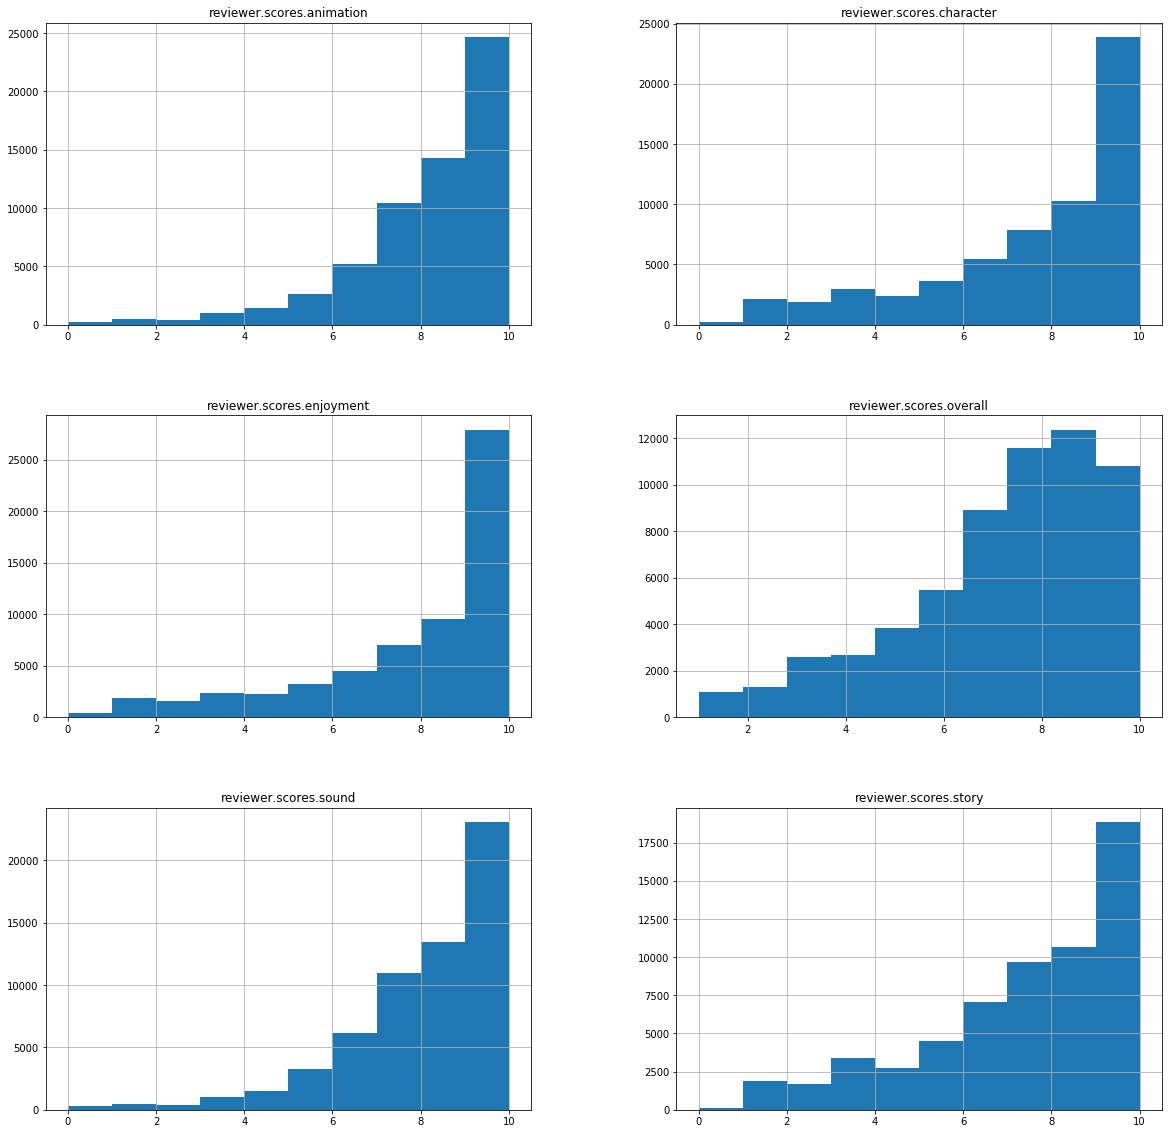

In [135]:
train_vector[all_scores].hist(figsize=(20,20))
plt.show()

In [136]:
train_vector[all_scores].apply(lambda x: x.value_counts())

,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.sound,reviewer.scores.story,reviewer.scores.overall
0,183,199,372,328,148,NaN
1,453,2146,1839,481,1916,1073.0
2,432,1870,1543,422,1681,1295.0
3,981,2918,2336,1019,3373,2593.0
4,1405,2392,2241,1505,2708,2665.0
5,2593,3642,3263,3232,4493,3827.0
6,5192,5451,4517,6122,7068,5471.0
7,10411,7858,7024,10990,9690,8905.0
8,14288,10238,9535,13450,10685,11581.0
9,12561,10459,10850,11087,9176,12374.0


In [137]:
scores_counts = train_vector[all_scores].apply(lambda x: x.value_counts())
total_counts = scores_counts.sum(axis=1).sum(axis=0)
print("Percent of scores from 0 to 6: ", scores_counts.iloc[:7,:].sum(axis=1).sum(axis=0) / total_counts)
print("Percent of scores from 7 to 8: ", scores_counts.iloc[7:9,:].sum(axis=1).sum(axis=0) / total_counts)
print("Percent of scores from 9 to 10: ", scores_counts.iloc[9:,:].sum(axis=1).sum(axis=0) / total_counts)

Percent of scores from 0 to 6:  0.2678482043158028
Percent of scores from 7 to 8:  0.3428411909987514
Percent of scores from 9 to 10:  0.38931060468544587


Bin scores into one of three categories: negative, neutral, positive

In [138]:
def encode_score(X, score_str, prefix, labels=["Negative", "Neutral", "Positive"], bins=[0,6,8,10]):
    labels = [prefix + label for label in labels]
    return pd.get_dummies(pd.cut(X[score_str], bins=bins, include_lowest=True, labels=labels))

In [139]:
for score_name in all_scores:
    score_type = score_name.split(".")[2]
    score = encode_score(train_vector, score_name, score_type + "_")
    train_vector = train_vector.join(score, how="left")

In [140]:
train_vector.drop(labels=all_scores, axis=1, inplace=True)

In [141]:
train_vector.head()

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,docvec_0,docvec_1,docvec_2,docvec_3,docvec_4,docvec_5,docvec_6,docvec_7,docvec_8,docvec_9,docvec_10,docvec_11,docvec_12,docvec_13,docvec_14,docvec_15,docvec_16,docvec_17,docvec_18,docvec_19,docvec_20,docvec_21,docvec_22,docvec_23,docvec_24,docvec_25,docvec_26,docvec_27,docvec_28,docvec_29,docvec_30,docvec_31,docvec_32,docvec_33,docvec_34,docvec_35,docvec_36,docvec_37,docvec_38,docvec_39,docvec_40,docvec_41,docvec_42,docvec_43,docvec_44,docvec_45,docvec_46,docvec_47,docvec_48,docvec_49,docvec_50,docvec_51,docvec_52,docvec_53,docvec_54,docvec_55,docvec_56,docvec_57,docvec_58,docvec_59,docvec_60,docvec_61,docvec_62,docvec_63,docvec_64,docvec_65,docvec_66,docvec_67,docvec_68,docvec_69,docvec_70,docvec_71,docvec_72,docvec_73,docvec_74,docvec_75,docvec_76,docvec_77,docvec_78,docvec_79,docvec_80,docvec_81,docvec_82,docvec_83,docvec_84,docvec_85,docvec_86,docvec_87,docvec_88,docvec_89,docvec_90,docvec_91,docvec_92,docvec_93,docvec_94,docvec_95,docvec_96,docvec_97,docvec_98,docvec_99,animation_Negative,animation_Neutral,animation_Positive,character_Negative,character_Neutral,character_Positive,enjoyment_Negative,enjoyment_Neutral,enjoyment_Positive,sound_Negative,sound_Neutral,sound_Positive,story_Negative,story_Neutral,story_Positive,overall_Negative,overall_Neutral,overall_Positive
0,8426,Hourou Musuko,232931,catcupcakes,This was a show I decided to watch on a whim o...,2016-10-30 19:44:00+00:00,1,11,1.080740,-1.689326,0.280989,1.213978,1.251429,-1.503841,-1.464203,0.013494,0.854812,-0.001600,-0.981685,-0.077378,-0.221890,-0.610173,0.852703,-0.716176,0.394199,0.199221,-0.771814,-0.067870,1.109169,-0.893586,1.581535,0.178041,0.480514,-0.014135,1.114745,0.925915,-0.309333,1.472071,-0.111341,-0.010307,-0.567599,-0.046492,-2.028070,-0.994556,0.765735,-0.097645,-0.158931,-1.210363,0.522571,-0.518669,-0.119604,-1.144396,-1.554564,1.693264,-2.847970,1.279876,-0.166049,-0.209001,0.763666,0.489597,-2.232710,-0.394933,1.110097,1.315074,0.655980,0.384832,0.460551,-0.598246,0.163514,0.446881,0.415636,0.986113,-0.242324,-1.126107,1.061150,-1.111772,-0.392104,-0.007419,0.456773,-0.201821,-0.922988,-0.590775,-1.171284,1.675909,-0.163367,-0.062926,0.256743,0.182071,1.862965,1.728196,-0.777169,1.419113,-0.523093,-0.735064,-0.134833,-1.714463,0.154433,0.098459,0.323704,1.272071,-0.584374,0.484996,1.449803,1.958048,2.064259,0.575998,0.105818,-1.496938,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1
1,3712,Zero no Tsukaima: Princesses no Rondo,33853,ymir233,"I don't care how well a formula works, when it...",2011-01-18 08:39:00+00:00,71,12,0.604441,1.235665,0.878977,1.087371,-0.474285,-0.141517,1.032550,-0.278179,-0.455750,-1.953818,0.590932,-0.049231,-0.524138,-1.745069,0.378260,0.514148,-0.291248,1.639043,-0.101752,0.053575,-1.033280,0.287528,-0.298720,1.185541,-0.762641,-0.555532,-0.026127,-1.356394,-1.122310,-0.022762,-1.534956,0.254654,-0.136406,0.195956,0.200714,-1.969192,-0.514229,0.897864,-1.503898,-0.518444,-0.543111,-0.505114,0.633079,-0.555414,0.053516,-2.225251,-0.843581,-0.302368,-0.263229,-0.079520,-1.883823,0.442215,0.958220,-1.758997,-0.199507,2.422875,1.489736,1.278713,-0.423920,0.253818,0.651533,-0.622506,0.384946,0.992677,-0.083208,-0.461164,-1.458533,-0.549319,-0.215845,0.950027,-1.074504,0.534737,-0.138289,-1.129272,0.327967,0.420651,-0.256837,0.856622,0.803996,1.988377,1.258693,0.157588,-1.424624,-0.470647,0.882508,-1.813630,0.884202,-0.487689,0.729301,-0.860453,-0.599642,0.380691,0.589956,1.898925,-0.314873,0.206817,-0.850226,-2.813031,0.291829,-1.075245,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0
2,1604,Katekyo Hitman Reborn!,72813,Forever-Noir,This series was initially shown to me by a fri...,2012-09-20 22:24:00+00:00,8,203,1.933980,0.104681,0.244268,-2.467623,0.157275,0.041990,1.065886,0.648777,-0.471577,-1.034240,-0.232850,0.287572,-1.145396,1.737558,-1.257196,-1.144624,-0.780555,0.185943,-1.775328,0.331497,0.434244,0.863050,1.079982,-2.247351,0.104764,-0.143045,-1

In [155]:
train_vector.to_hdf("data/mal_reviews_one_hot_scores_train.hdf5", "table")

## Preparing the test set

In [143]:
nlp = spacy.load("en_core_web_lg")

In [144]:
vectors = []
for i, (index, row) in enumerate(test_reviews.iterrows()):
    doc = prep.tokenize_text(row["content"], nlp)
    doc = [word for word in doc.text.split(" ")]
    vector = model.infer_vector(doc)
    vectors.append(vector)

In [145]:
vectors = np.vstack(vectors)

In [146]:
test_vector = pd.DataFrame(pd.np.column_stack([test_reviews, vectors]))

In [149]:
test_vector.rename(columns={i:name for i, name in enumerate(test_reviews.columns)},
                    inplace=True)
test_vector.rename(columns={i:"docvec_"+str(i-14) for i in range(14,114)},
                    inplace=True)

In [150]:
test_vector.head()

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,reviewer.scores.animation,reviewer.scores.character,reviewer.scores.enjoyment,reviewer.scores.overall,reviewer.scores.sound,reviewer.scores.story,docvec_0,docvec_1,docvec_2,docvec_3,docvec_4,docvec_5,docvec_6,docvec_7,docvec_8,docvec_9,docvec_10,docvec_11,docvec_12,docvec_13,docvec_14,docvec_15,docvec_16,docvec_17,docvec_18,docvec_19,docvec_20,docvec_21,docvec_22,docvec_23,docvec_24,docvec_25,docvec_26,docvec_27,docvec_28,docvec_29,docvec_30,docvec_31,docvec_32,docvec_33,docvec_34,docvec_35,docvec_36,docvec_37,docvec_38,docvec_39,docvec_40,docvec_41,docvec_42,docvec_43,docvec_44,docvec_45,docvec_46,docvec_47,docvec_48,docvec_49,docvec_50,docvec_51,docvec_52,docvec_53,docvec_54,docvec_55,docvec_56,docvec_57,docvec_58,docvec_59,docvec_60,docvec_61,docvec_62,docvec_63,docvec_64,docvec_65,docvec_66,docvec_67,docvec_68,docvec_69,docvec_70,docvec_71,docvec_72,docvec_73,docvec_74,docvec_75,docvec_76,docvec_77,docvec_78,docvec_79,docvec_80,docvec_81,docvec_82,docvec_83,docvec_84,docvec_85,docvec_86,docvec_87,docvec_88,docvec_89,docvec_90,docvec_91,docvec_92,docvec_93,docvec_94,docvec_95,docvec_96,docvec_97,docvec_98,docvec_99
0,10456,Kyoukaisenjou no Horizon,273779,PandicornH,3/10\r\nAlthough I totally get why other peopl...,2018-03-14 05:13:00+00:00,2,13,8,4,2,3,7,2,-1.89524,-0.48446,0.188747,1.73976,-0.846955,-0.871146,-0.859576,-0.85257,-1.62132,-0.466836,0.862752,1.55828,-0.975239,-1.11201,0.680811,1.34068,-0.709026,-1.42106,-0.387895,2.1914,-1.19584,-0.650855,-1.42405,0.397749,0.201794,-1.76368,1.35189,-1.66008,-0.982818,0.176721,0.336289,-0.536736,-0.66487,-1.68836,0.35395,-0.698471,-0.838248,2.50394,-0.796443,-1.46137,1.83919,1.2029,-3.11019,-1.46969,-1.40853,0.580268,1.3837,-1.21632,0.248019,3.22546,0.793607,1.59992,0.872824,-0.610526,0.78775,1.40678,-1.29865,-1.60767,-0.0977728,0.532806,2.1016,0.983877,-1.90009,1.41046,-0.961475,-0.310709,0.0725676,1.60647,0.339708,-0.182715,0.720414,-1.27572,-0.439118,2.42574,-0.239964,-0.170244,1.2274,1.81313,-1.53432,0.393446,0.392027,-1.02107,0.975187,1.94731,-0.26791,-0.857213,2.831,1.74443,0.188104,-0.715017,-0.0369715,-0.451283,-1.04283,-2.04603,1.40516,-0.928309,2.97276,-0.866956,-1.74808,-1.86296
1,1530,Kanon (2006),82716,notesec,Predictable to the very end. Cliche and annoyi...,2013-01-05 04:49:00+00:00,1,24,9,3,3,6,4,7,0.451736,0.321996,0.085593,0.832906,-0.182292,0.0106514,0.304598,0.0697901,-0.518134,-0.278451,-0.0326222,1.08671,0.448942,-1.80843,-0.15826,0.478091,-0.399693,-0.420658,0.0744839,0.398191,-0.825965,-0.531599,-0.903023,0.435009,0.837263,-0.370467,0.420644,-1.58205,-0.274054,0.0329191,0.278387,0.324531,0.578392,0.0236998,-0.680848,-0.344834,0.181056,-0.590254,-0.532683,0.0447183,-0.199765,-0.40874,0.265764,-0.18323,-1.01625,0.308242,0.19493,0.612275,-0.0985166,0.331537,0.469296,-0.736018,-0.449253,0.694835,-0.426701,-0.154161,-0.996312,0.248107,0.392184,-0.132369,0.621039,-0.939685,0.00157723,0.222249,-0.743798,0.771053,-0.280539,0.593062,0.235311,-0.976165,0.269421,-0.757175,-0.330309,0.0574693,-0.470312,-0.20938,0.321535,-0.233486,-0.768798,-0.0412064,-0.568113,-0.565899,0.494536,-0.191426,0.536395,-0.579841,1.05745,0.684106,-0.498695,-1.10264,-0.0616121,-0.176011,-0.0514986,-0.0509825,0.254927,0.466719,0.534658,-0.190861,-0.228391,-0.219399
2,23283,Zankyou no Terror,167321,Nurtan-kun,* Nurtan-kun short reviews *\r\nThis anime is ...,2014-11-03 13:02:00+00:00,11,11,10,10,8,8,10,8,-0.602323,-0.176872,-0.908284,1.56967,0.302773,0.812972,1.99477,0.301092,-1.01356,-1.3586,1.91396,-0.770446,0.525726,-0.806436,-0.913087,-0.214705,-0.644152,2.01973,-0.192679,-0.510224,0.307463,0.0344154,-1.84434,-0.0414954,0.198525,-0.873088,0.698104,-0.344617,-1.21052,-1.33133,0.0830676,-0.431355,-0.424368,1.02742,-1.68085,-2.05422,-0.275862,0.73216,-0.771429,0.67041,-1.30134,0.798435,-0.277679,-0.8007,0.766331,0.52664,0.345803,0.680477,0.585991,-0.453226,-0.632586,-0.143282,-2.17989,0.348635,-0.87183,-0.95

In [151]:
for score_name in all_scores:
    score_type = score_name.split(".")[2]
    score = encode_score(test_vector, score_name, score_type + "_")
    test_vector = test_vector.join(score, how="left")

In [152]:
test_vector.drop(labels=all_scores, axis=1, inplace=True)

In [153]:
test_vector.head()

,mal_id,title,review_id,reviewer,content,date,helpful_count,reviewer.episodes_seen,docvec_0,docvec_1,docvec_2,docvec_3,docvec_4,docvec_5,docvec_6,docvec_7,docvec_8,docvec_9,docvec_10,docvec_11,docvec_12,docvec_13,docvec_14,docvec_15,docvec_16,docvec_17,docvec_18,docvec_19,docvec_20,docvec_21,docvec_22,docvec_23,docvec_24,docvec_25,docvec_26,docvec_27,docvec_28,docvec_29,docvec_30,docvec_31,docvec_32,docvec_33,docvec_34,docvec_35,docvec_36,docvec_37,docvec_38,docvec_39,docvec_40,docvec_41,docvec_42,docvec_43,docvec_44,docvec_45,docvec_46,docvec_47,docvec_48,docvec_49,docvec_50,docvec_51,docvec_52,docvec_53,docvec_54,docvec_55,docvec_56,docvec_57,docvec_58,docvec_59,docvec_60,docvec_61,docvec_62,docvec_63,docvec_64,docvec_65,docvec_66,docvec_67,docvec_68,docvec_69,docvec_70,docvec_71,docvec_72,docvec_73,docvec_74,docvec_75,docvec_76,docvec_77,docvec_78,docvec_79,docvec_80,docvec_81,docvec_82,docvec_83,docvec_84,docvec_85,docvec_86,docvec_87,docvec_88,docvec_89,docvec_90,docvec_91,docvec_92,docvec_93,docvec_94,docvec_95,docvec_96,docvec_97,docvec_98,docvec_99,animation_Negative,animation_Neutral,animation_Positive,character_Negative,character_Neutral,character_Positive,enjoyment_Negative,enjoyment_Neutral,enjoyment_Positive,sound_Negative,sound_Neutral,sound_Positive,story_Negative,story_Neutral,story_Positive,overall_Negative,overall_Neutral,overall_Positive
0,10456,Kyoukaisenjou no Horizon,273779,PandicornH,3/10\r\nAlthough I totally get why other peopl...,2018-03-14 05:13:00+00:00,2,13,-1.89524,-0.48446,0.188747,1.73976,-0.846955,-0.871146,-0.859576,-0.85257,-1.62132,-0.466836,0.862752,1.55828,-0.975239,-1.11201,0.680811,1.34068,-0.709026,-1.42106,-0.387895,2.1914,-1.19584,-0.650855,-1.42405,0.397749,0.201794,-1.76368,1.35189,-1.66008,-0.982818,0.176721,0.336289,-0.536736,-0.66487,-1.68836,0.35395,-0.698471,-0.838248,2.50394,-0.796443,-1.46137,1.83919,1.2029,-3.11019,-1.46969,-1.40853,0.580268,1.3837,-1.21632,0.248019,3.22546,0.793607,1.59992,0.872824,-0.610526,0.78775,1.40678,-1.29865,-1.60767,-0.0977728,0.532806,2.1016,0.983877,-1.90009,1.41046,-0.961475,-0.310709,0.0725676,1.60647,0.339708,-0.182715,0.720414,-1.27572,-0.439118,2.42574,-0.239964,-0.170244,1.2274,1.81313,-1.53432,0.393446,0.392027,-1.02107,0.975187,1.94731,-0.26791,-0.857213,2.831,1.74443,0.188104,-0.715017,-0.0369715,-0.451283,-1.04283,-2.04603,1.40516,-0.928309,2.97276,-0.866956,-1.74808,-1.86296,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0
1,1530,Kanon (2006),82716,notesec,Predictable to the very end. Cliche and annoyi...,2013-01-05 04:49:00+00:00,1,24,0.451736,0.321996,0.085593,0.832906,-0.182292,0.0106514,0.304598,0.0697901,-0.518134,-0.278451,-0.0326222,1.08671,0.448942,-1.80843,-0.15826,0.478091,-0.399693,-0.420658,0.0744839,0.398191,-0.825965,-0.531599,-0.903023,0.435009,0.837263,-0.370467,0.420644,-1.58205,-0.274054,0.0329191,0.278387,0.324531,0.578392,0.0236998,-0.680848,-0.344834,0.181056,-0.590254,-0.532683,0.0447183,-0.199765,-0.40874,0.265764,-0.18323,-1.01625,0.308242,0.19493,0.612275,-0.0985166,0.331537,0.469296,-0.736018,-0.449253,0.694835,-0.426701,-0.154161,-0.996312,0.248107,0.392184,-0.132369,0.621039,-0.939685,0.00157723,0.222249,-0.743798,0.771053,-0.280539,0.593062,0.235311,-0.976165,0.269421,-0.757175,-0.330309,0.0574693,-0.470312,-0.20938,0.321535,-0.233486,-0.768798,-0.0412064,-0.568113,-0.565899,0.494536,-0.191426,0.536395,-0.579841,1.05745,0.684106,-0.498695,-1.10264,-0.0616121,-0.176011,-0.0514986,-0.0509825,0.254927,0.466719,0.534658,-0.190861,-0.228391,-0.219399,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
2,23283,Zankyou no Terror,167321,Nurtan-kun,* Nurtan-kun short reviews *\r\nThis anime is ...,2014-11-03 13:02:00+00:00,11,11,-0.602323,-0.176872,-0.908284,1.56967,0.302773,0.812972,1.99477,0.301092,-1.01356,-1.3586,1.91396,-0.770446,0.525726,-0.806436,-0.913087,-0.214705,-0.644152,2.01973,-0.192679,-0.510224,0.307463,0.0344154,-1.84434,-0.0414954,0.198525,-0.873088,0.698104,-0.344617,-1.21052,-1.33133,0.0830676,-0.431355,-0.424368,1.02742,-1.

In [154]:
test_vector.to_hdf("data/mal_reviews_one_hot_scores_test.hdf5", "table")

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->['mal_id', 'title', 'review_id', 'reviewer', 'content', 'date', 'helpful_count', 'reviewer.episodes_seen', 'docvec_0', 'docvec_1', 'docvec_2', 'docvec_3', 'docvec_4', 'docvec_5', 'docvec_6', 'docvec_7', 'docvec_8', 'docvec_9', 'docvec_10', 'docvec_11', 'docvec_12', 'docvec_13', 'docvec_14', 'docvec_15', 'docvec_16', 'docvec_17', 'docvec_18', 'docvec_19', 'docvec_20', 'docvec_21', 'docvec_22', 'docvec_23', 'docvec_24', 'docvec_25', 'docvec_26', 'docvec_27', 'docvec_28', 'docvec_29', 'docvec_30', 'docvec_31', 'docvec_32', 'docvec_33', 'docvec_34', 'docvec_35', 'docvec_36', 'docvec_37', 'docvec_38', 'docvec_39', 'docvec_40', 'docvec_41', 'docvec_42', 'docvec_43', 'docvec_44', 'docvec_45', 'docvec_46', 'docvec_47', 'docvec_48', 'docvec_49', 'd